**Get the data ready for training**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import all library**

In [ ]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import os





**Custom data generator keras**

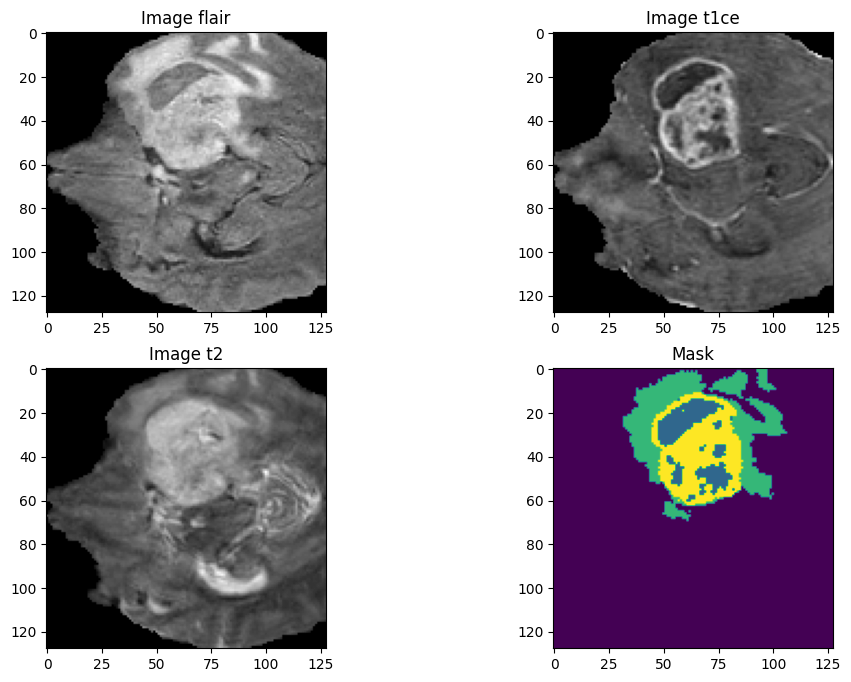

In [ ]:
# https://youtu.be/PNqnLbzdxwQ
"""
Custom data generator to work with BraTS2020 dataset.
Can be used as a template to create your own custom data generators.
No image processing operations are performed here, just load data from local directory
in batches.
"""

#from tifffile import imsave, imread

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)

            images.append(image)
    images = np.array(images)

    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)
    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

############################################

#Test the generator

from matplotlib import pyplot as plt
import random
# Modify the directory paths to correctly point to your data in Google Drive
train_img_dir = "/content/drive/My Drive/input_data_128/train/images/"
train_mask_dir = "/content/drive/My Drive/input_data_128/train/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
# Import the function from Cell A
from IPython import get_ipython
import sys


**U-net Model**

In [ ]:
# https://youtu.be/ScdCQqLtnis
"""
@author: Sreenivas Bhattiprolu
Converted my standard 2D Unet to 3D.
"""

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


** Training Data**

In [ ]:
!pip install keras

In [ ]:
!pip install imageLoader

In [ ]:
import os
import numpy as np
import keras
from matplotlib import pyplot as plt
import glob
import random
from keras.models import load_model



In [ ]:
!pip install segmentation_models_3D

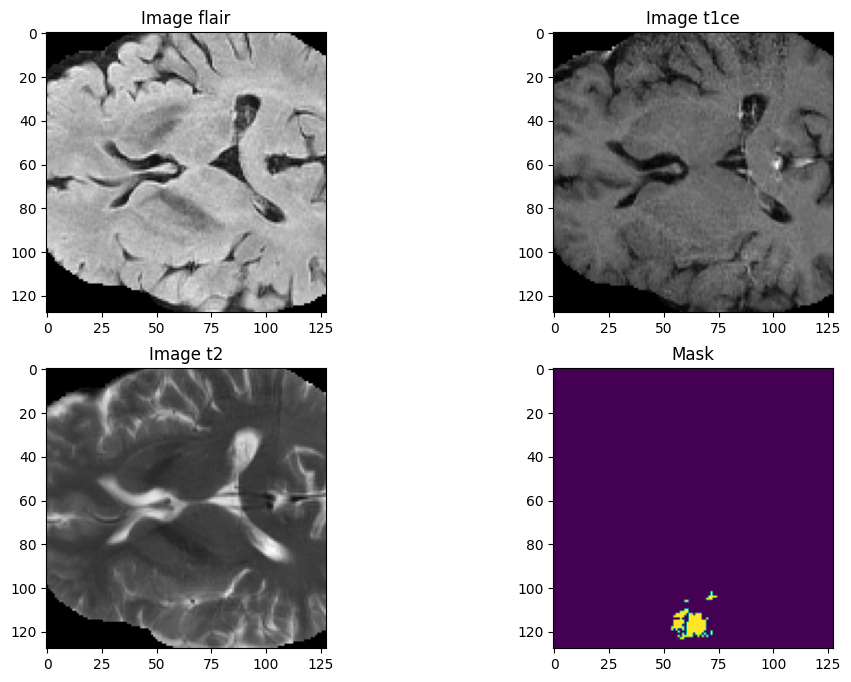

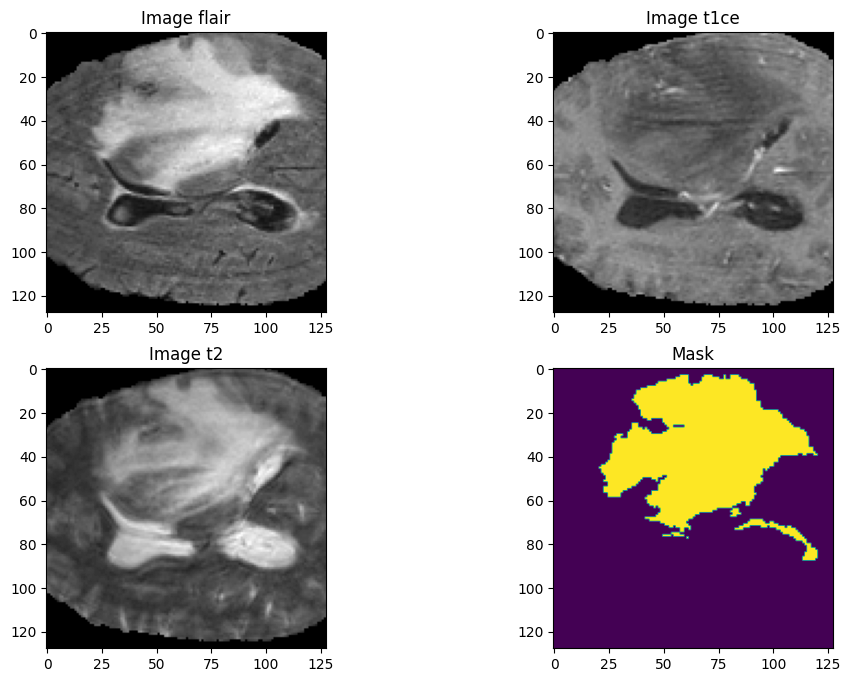

Segmentation Models: using `tf.keras` framework.


In [ ]:

train_img_dir = "/content/drive/My Drive/input_data_128/train/images/"
train_mask_dir = "/content/drive/My Drive/input_data_128/train/masks/"
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

#Define the image generators for training and validation

train_img_dir = "/content/drive/My Drive/input_data_128/train/images/"
train_mask_dir = "/content/drive/My Drive/input_data_128/train/masks/"

val_img_dir = "/content/drive/My Drive/input_data_128/val/images/"
val_mask_dir = "/content/drive/My Drive/input_data_128/val/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                    train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                    val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
import tensorflow as tf
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = categorical_focal_loss()
total_loss = dice_loss + (1 * focal_loss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.001
optim = keras.optimizers.Adam(LR)

**Fit the Model**

In [ ]:
# Import the function from Cell A
from IPython import get_ipython
import sys

#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


# from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128,
                              IMG_WIDTH=128,
                              IMG_DEPTH=128,
                              IMG_CHANNELS=3,
                              num_classes=4)

model.compile(optimizer = optim, loss=combined_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [ ]:
history=model.fit(train_img_datagen,
              steps_per_epoch=steps_per_epoch,
              epochs=100,
              verbose=1,
              validation_data=val_img_datagen,
              validation_steps=val_steps_per_epoch,
              )
#model.save('brats_3d.hdf5')

#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
#my_model = load_model('saved_models/brats_3d.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
#my_model = load_model('saved_models/brats_3d.hdf5',
                          #custom_objects={'dice_loss_plus_1focal_loss': total_loss})

Epoch 1/100
 13/128 ━━━━━━━━━━━━━━━━━━━━ 14:20 7s/step - accuracy: 0.7653 - iou_score: 0.1515 - loss: 1.1142

KeyboardInterrupt: 

In [ ]:
model.save('/content/drive/My Drive/brats_3d_70.hdf5')

In [ ]:
my_model = load_model('/content/drive/My Drive/brats_3d_50.hdf5',
                          custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                          'iou_score':sm.metrics.IOUScore(threshold=0.5)})



#Now all set to continue the training process.
history2=my_model.fit(train_img_datagen,
              steps_per_epoch=steps_per_epoch,
              epochs=30,
              verbose=1,
              validation_data=val_img_datagen,
              validation_steps=val_steps_per_epoch,
              )
#################################################
loss = history2.history['loss']
val_loss = history.history['val_loss']

##################################################

TypeError: Error when deserializing class 'Conv3DTranspose' using config={'name': 'conv3d_transpose_4', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [2, 2, 2], 'strides': [2, 2, 2], 'padding': 'same', 'data_format': 'channels_last', 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv3DTranspose: {'groups': 1}

In [ ]:
my_model.save('/content/drive/My Drive/brats_3d_70.hdf5')

In [ ]:
#For predictions you do not need to compile the model, so ...
my_model = load_model('/content/drive/My Drive/brats_3d_70.hdf5',
                          compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=2 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                    val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

TypeError: Error when deserializing class 'Conv3DTranspose' using config={'name': 'conv3d_transpose_12', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [2, 2, 2], 'strides': [2, 2, 2], 'padding': 'same', 'data_format': 'channels_last', 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv3DTranspose: {'groups': 1}

In [ ]:

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 100
print("image number:",img_num)

test_img = np.load("/content/drive/My Drive/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/My Drive/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

n_slice=random.randint(0, test_prediction_argmax.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
#plt.savefig(f'/content/drive/My Drive/image_{img_num}.png')
plt.show()


